In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import warnings
warnings.filterwarnings('ignore')

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Inspect Stations table
stations = engine.execute('SELECT * FROM Station')
print(stations.keys())

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [9]:
stations.fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [10]:
columns=inspector.get_columns('Station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Inspect Measurement Table
measurements = engine.execute("SELECT * FROM Measurement LIMIT 15")
print(measurements.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [12]:
measurements.fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0)]

In [13]:
columns = inspector.get_columns("Measurement")
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = (session.query(Measurement.date)
                           .order_by(Measurement.date.desc())
                           .first())
most_recent_date

('2017-08-23')

Query Date: 2016-08-22


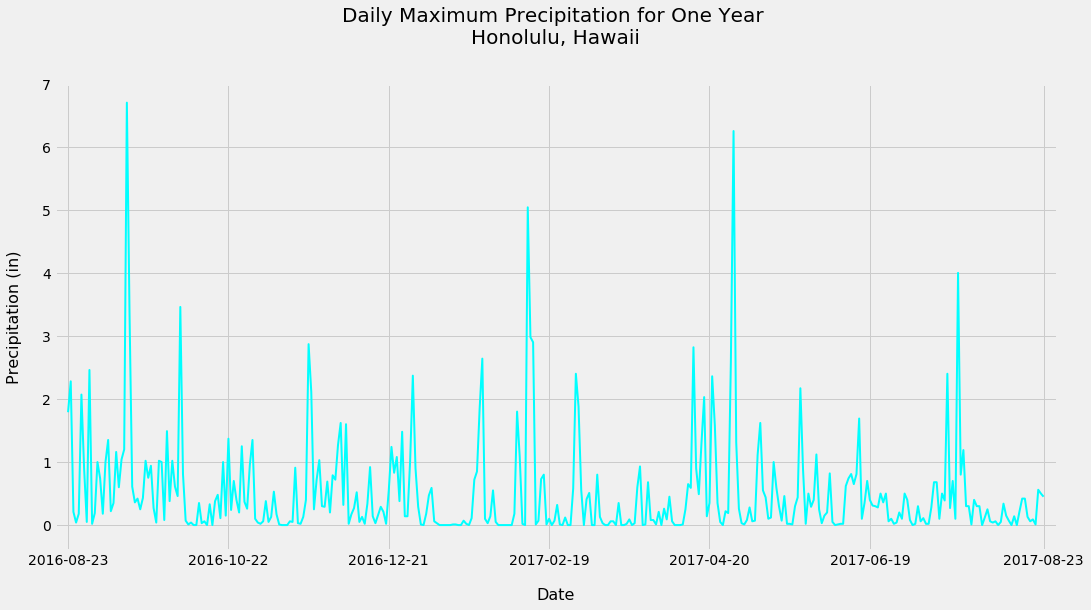

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print('Query Date:', year_ago_date)

# Perform a query to retrieve the data and precipitation scores
year_prcp = (session.query(Measurement.date,func.max(Measurement.prcp))
                    .filter(func.strftime('%Y-%m-%d', Measurement.date) > year_ago_date)
                    .group_by(Measurement.date)
                    .all())
year_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(year_prcp, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)
prcp_df.head(10)

# Sort the dataframe by date
prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(16,8)
prcp_df.plot(linewidth=2, alpha=1, rot=0,
             xticks = (0,60,120,180,240,300,365),
             color = 'xkcd:cyan')
plt.xlim(-5,370)
plt.ylim(-0.4,7)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.legend('',frameon=False)
plt.xlabel('Date',fontsize=16,color='black',labelpad=20)
plt.ylabel('Precipitation (in)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Maximum Precipitation for One Year \nHonolulu, Hawaii',fontsize=20,pad=40)

plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_stats = (session.query(Measurement.date, Measurement.prcp)
                          .filter(Measurement.date > year_ago_date)
                          .all())
year_prcp_stats
year_prcp_stats_df = pd.DataFrame(year_prcp_stats, columns=['date', 'prcp'])
year_prcp_stats_df
year_prcp_stats_df.dropna()
year_prcp_stats_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
tot_stations = session.query(Station).count()
print(f'There are {tot_stations} stations at Honolulu, Hawaii.')

There are 9 stations at Honolulu, Hawaii.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = (session.query(Measurement.station,func.count(Measurement.station))
                            .group_by(Measurement.station)
                            .order_by(func.count(Measurement.station).desc())
                            .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs = [Measurement.station,
           func.min(Measurement.tobs),
           func.max(Measurement.tobs),
           func.avg(Measurement.tobs)]

most_active_st = (session.query(*tobs)
                         .filter(Measurement.station == 'USC00519281')
                         .all())
most_active_st

most_active_st_temp = pd.DataFrame(most_active_st, columns = ['station', 'min_temp', 'max_temp', 'avg_temp'])
most_active_st_temp.set_index('station', inplace=True)
most_active_st_temp

,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs = (session.query(Measurement.date,(Measurement.tobs))
                    .filter(func.strftime(Measurement.date) > year_ago_date)
                    .filter(Measurement.station == 'USC00519281')
                    .all())
year_tobs

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text yticklabel objects>)

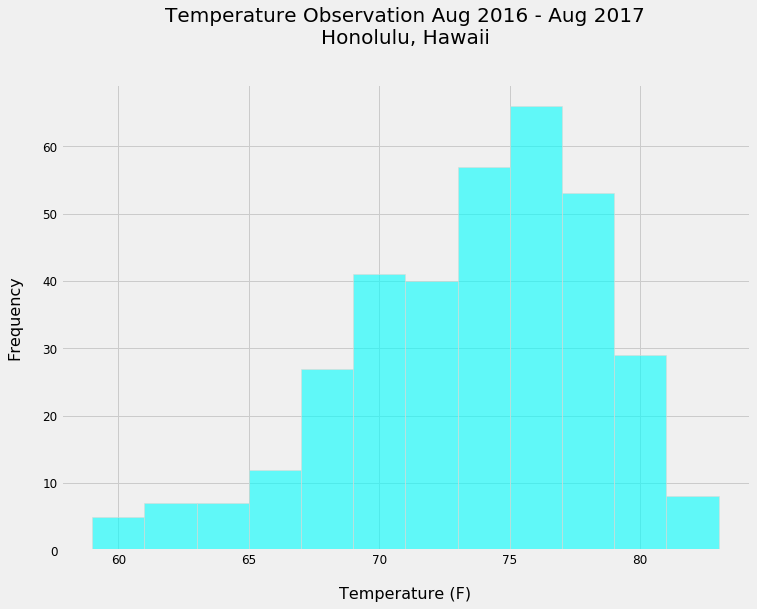

In [22]:
tobs_df = pd.DataFrame(year_tobs)
tobs_df.set_index('date', inplace=True)

plt.rcParams['figure.figsize']=(11,8)
plt.hist(tobs_df['tobs'],bins=12,alpha=0.6,edgecolor='xkcd:light gray',
         linewidth=1,color='xkcd:cyan')

plt.title('Temperature Observation Aug 2016 - Aug 2017\nHonolulu, Hawaii', fontsize=20,pad=40)
plt.xlabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='black',labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Close session

In [ ]:
# Close Session
session.close()